In [1]:
import BitVector
import xxhash
import sys
import os
import urllib.request
import shutil
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
class HashXX32(object):
    def __init__(self, seed):
        self.h = xxhash.xxh32(seed=seed)

    def hash(self, o):
        self.h.reset()
        self.h.update(o)
        return self.h.intdigest() % sys.maxsize
    
class Bloom(object):
    def __init__(self, size, hashes):
        self.hashes = hashes
        self.size = size
        self.bv = BitVector.BitVector(size=size)
    
    def add(self, o):
        for hsh in self.hashes:
            self.bv[hsh.hash(o) % self.size] = 1

    def naive_containment(self, bloom):
        # "Naive" b/c there's no accounting for collisions
        nset, n, i = 0, 0, self.bv.next_set_bit(0)
        while i >= 0:
            if bloom.bv[i]: nset += 1
            n += 1
            i = self.bv.next_set_bit(i+1)
        return float(nset)/n

In [4]:
def new_sketch():
    return Bloom(80000, list(HashXX32(i) for i in range(10)))

In [5]:
url = 'https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt'
fn = 't8.shakespeare.txt'

#if not os.path.exists(fn):
if True:
    print('Downloading shakespeare to "%s"...' % fn, file=sys.stderr)
    with urllib.request.urlopen(url) as response, open(fn, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

name, buf, sketches, works = '', [], [], []
remove_nonalpha = re.compile(r'\W+')

with open(fn, 'rt') as fh:
    for ln in fh:
        ln = ln.strip()
        if ln.startswith('by William Shakespeare'):
            buf = buf[-3:]
            name = buf[0] or buf[1]
            if name == "A LOVER'S COMPLAINT":
                # Skip this one
                name = ''
                break
            print(name)
            works.append(name)
            sketches.append(new_sketch())
        if name != '':
            for tok in ln.split():
                sketches[-1].add(remove_nonalpha.sub('', tok.lower()))
        buf.append(ln)

if name != '':
    print(name)

THE SONNETS
ALLS WELL THAT ENDS WELL
THE TRAGEDY OF ANTONY AND CLEOPATRA
AS YOU LIKE IT
THE COMEDY OF ERRORS
THE TRAGEDY OF CORIOLANUS
CYMBELINE
THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
THE FIRST PART OF KING HENRY THE FOURTH
SECOND PART OF KING HENRY IV
THE LIFE OF KING HENRY THE FIFTH
THE FIRST PART OF HENRY THE SIXTH
THE SECOND PART OF KING HENRY THE SIXTH
THE THIRD PART OF KING HENRY THE SIXTH
KING HENRY THE EIGHTH
KING JOHN
THE TRAGEDY OF JULIUS CAESAR
THE TRAGEDY OF KING LEAR
LOVE'S LABOUR'S LOST
THE TRAGEDY OF MACBETH
MEASURE FOR MEASURE
THE MERCHANT OF VENICE
THE MERRY WIVES OF WINDSOR
A MIDSUMMER NIGHT'S DREAM
MUCH ADO ABOUT NOTHING
THE TRAGEDY OF OTHELLO, MOOR OF VENICE
KING RICHARD THE SECOND
KING RICHARD III
THE TRAGEDY OF ROMEO AND JULIET
THE TAMING OF THE SHREW
THE TEMPEST
THE LIFE OF TIMON OF ATHENS
THE TRAGEDY OF TITUS ANDRONICUS
THE HISTORY OF TROILUS AND CRESSIDA
TWELFTH NIGHT; OR, WHAT YOU WILL
THE TWO GENTLEMEN OF VERONA
THE WINTER'S TALE


In [10]:
def query_shakespeare_containment(works, sketches, text):
    query_sketch = new_sketch()
    for word in text.strip().split():
        query_sketch.add(word)
    containments = {}
    for work, sketch in zip(works, sketches):
        containments[work] = query_sketch.naive_containment(sketch)
    # linearly spread them out from 0 to 1
    mn, mx = min(containments.values()), max(containments.values())
    if mn != mx:
        for k in containments:
            containments[k] = (containments[k] - mn + 0.000001) / (mx - mn)
            containments[k] = containments[k] * containments[k]
    print(containments)
    wordcloud = WordCloud(
        background_color='white',
        width=700,
        height=300).generate_from_frequencies(containments)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

{'THE SONNETS': 0.055363875433910026, 'ALLS WELL THAT ENDS WELL': 0.12456830449965399, 'THE TRAGEDY OF ANTONY AND CLEOPATRA': 0.08650588235432526, 'AS YOU LIKE IT': 0.013841107267820073, 'THE COMEDY OF ERRORS': 1.3840830449826987e-12, 'THE TRAGEDY OF CORIOLANUS': 0.08650588235432526, 'CYMBELINE': 0.013841107267820073, 'THE TRAGEDY OF HAMLET, PRINCE OF DENMARK': 0.08650588235432526, 'THE FIRST PART OF KING HENRY THE FOURTH': 0.08650588235432526, 'SECOND PART OF KING HENRY IV': 0.013841107267820073, 'THE LIFE OF KING HENRY THE FIFTH': 0.22145439446505188, 'THE FIRST PART OF HENRY THE SIXTH': 0.031142283738408306, 'THE SECOND PART OF KING HENRY THE SIXTH': 1.3840830449826987e-12, 'THE THIRD PART OF KING HENRY THE SIXTH': 0.013841107267820073, 'KING HENRY THE EIGHTH': 0.031142283738408306, 'KING JOHN': 0.08650588235432526, 'THE TRAGEDY OF JULIUS CAESAR': 0.013841107267820073, 'THE TRAGEDY OF KING LEAR': 0.055363875433910026, "LOVE'S LABOUR'S LOST": 0.49827155709480964, 'THE TRAGEDY OF MACB

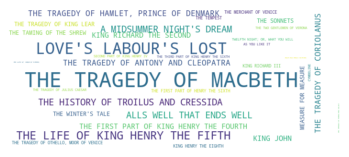

In [11]:
text = ''' banquo macbeth '''
query_shakespeare_containment(works, sketches, text)

In [12]:
text.strip().split()

['banquo', 'macbeth']